# E-prop training of dope RNN on hold task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


### E-prop factorization of the loss gradient

$$\frac{dE}{dW_{ij}} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} e_{ij}^t$$

where

$$
e_{ij}^t = \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial W_{ij}}
$$


Or, in vector format (note that $\frac{dE}{d\mathbf{w}_i}$, $\mathbf{e}_i^t$, and $\boldsymbol{\epsilon}_i^t$ are all row vectors):

$$\frac{dE}{d\mathbf{w}_i} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} \mathbf{e}_i^t = \sum_t L_i^t \mathbf{e}_i^t$$

where

$$
\mathbf{e}_i^t = \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
= \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \boldsymbol{\epsilon}_i^t
$$

with

$$
\boldsymbol{\epsilon}_i^t \equiv \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
$$

which can also be computed recursively:

$$
\boldsymbol{\epsilon}_i^1 = \frac{\partial \hat{x}_i^1}{\partial \mathbf{w}_i} \quad \quad \quad
\boldsymbol{\epsilon}_i^t = \frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \boldsymbol{\epsilon}_i^{t-1} + \frac{\partial \hat{x}_i^t}{\partial \mathbf{w}_i}
$$

In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def advance(x, z, w_T, u):
    psi = psi_fn(z)
    x_next = x + DT/TAU*(-x + C@w_T@psi + B@u)
    return x_next

In [3]:
# smln params
T = 1.1

LR = 0.01
NEPOCH = 400

# initial conditions
x_0 = torch.tensor([1., 1], device=device)
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
T_U_STIMS = [DT, T/2+DT]

# loss eval
DELAYS = [.06, .5]

## E-prop

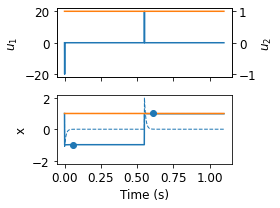

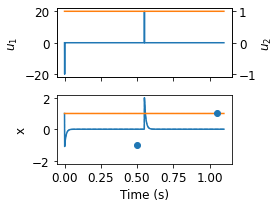

In [4]:
# use_approx = False
use_approx = True

losses_all = []

for DELAY in DELAYS:
    T_LOSSS = [T_U_STIM + DELAY for T_U_STIM in T_U_STIMS]

    IT = int(round(T/DT))
    t = np.arange(0, IT, dtype=float)*DT

    IT_U_STIMS = [int(round(T_U/DT)) for T_U in T_U_STIMS]
    IT_LOSSS = [int(round(T_LOSS/DT)) for T_LOSS in T_LOSSS]

    # specify loss
    MLOSS = torch.zeros((IT, D), device=device)
    MLOSS[IT_LOSSS, 0] = 1

    TARGS = torch.zeros((IT, D), device=device)
    TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

    def loss_fn(z_hats):
        return torch.mean(((z_hats - TARGS)**2)[MLOSS>0])

    w_T_hat = w_T_hat_0.clone().detach()
    w_T_hat.requires_grad = True

    losses = []
    z_hats_save = []

    # make inputs
    us = torch.zeros((IT, D), device=device)
    us[:, 1] = 1.
    us[IT_U_STIMS[0], 0] = -.02/DT
    us[IT_U_STIMS[1], 0] = .02/DT

    for epoch in range(NEPOCH):

        # forward pass
        x_hats = [x_0.clone()]
        z_hats = [get_z(x_hats[0])]

        for ct in range(1, IT):
            x_hat = advance(x_hats[ct-1], z_hats[ct-1], w_T_hat, us[ct, :])
            x_hat.retain_grad()

            z_hat = get_z(x_hat)
            z_hat.retain_grad()

            x_hats.append(x_hat)
            z_hats.append(z_hat)

        x_hats_cc = torch.stack(x_hats)
        z_hats_cc = torch.stack(z_hats)
        z_hats_cc.retain_grad()

        loss = loss_fn(z_hats_cc)

        loss.backward(retain_graph=True)  # compute grads along comp graph using autograd

        bptt_grad = w_T_hat.grad.clone()  # for reference/debugging
        w_T_hat.grad.zero_()

        # compute e-prop grad

        ## get eligibility vectors
        evs = torch.zeros((IT, D, N), device=device)  # each row is an e-vector

        for ct in range(1, IT):
            ## get relevant partial derivatives
            partial_x_hat, _, partial_w_T_hat, _ = torch.autograd.functional.jacobian(advance, inputs=(x_hats[ct-1], z_hats[ct-1], w_T_hat, us[ct, :]))
            ## loop over neurons to eligibility vectors
            for i in range(D):
                evs[ct, i, :] = partial_x_hat[i, i]*evs[ct-1, i, :] + partial_w_T_hat[i][i, :]

        ## convert to eligibility traces
        ets = 1*evs  # special case for identity activation function

        ## compute true gradient
        Ls = [z_hat.grad for z_hat in z_hats]  # learning signals
        e_prop_grad = torch.zeros((D, N), device=device)
        for ct in range(1, IT):
            e_prop_grad += Ls[ct][:, None]*ets[ct, i, :]

        ## compute approx gradient
        Ls_approx = [grad for grad in z_hats_cc.grad]  # learning signals (approx)
        e_prop_grad_approx = torch.zeros((D, N), device=device)
        for ct in range(1, IT):
            e_prop_grad_approx += Ls_approx[ct][:, None]*ets[ct, i, :]

        # update weights
        with torch.no_grad():
            if use_approx:
                w_T_hat -= LR*e_prop_grad_approx
            else:
                w_T_hat -= LR*e_prop_grad

        losses.append(loss.item())

        if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == NEPOCH):
            z_hats_save.append(z_hats_cc.clone().detach().numpy())
#         elif epoch in [1, 5, 10]:  # for debugging
#             print('Epoch', epoch)
#             print('BPTT grad:', bptt_grad)
#             print('Eprop grad:', e_prop_grad)
#             print('Eprop grad approx:', e_prop_grad_approx)
#             print('')

    losses_all.append(losses)
    
    # make plots
    fig, axs = plt.subplots(2, 1, figsize=(4, 3), tight_layout=True, sharex=True)
    
    axs[0].plot(t, us[:, 0])
    set_plot(axs[0], y_label=r'$u_1$')
    
    ax_0_twin = axs[0].twinx()
    ax_0_twin.plot(t, us[:, 1], c=colors[1], zorder=2)
    set_plot(ax_0_twin, y_lim=(-1.1, 1.1), y_label=r'$u_2$')
    
    for d, c in zip(range(D), colors):
        axs[1].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--', zorder=0)
        axs[1].plot(t, z_hats_save[-1][:, d], c=c, zorder=1)
        
    for itmloss, cmloss in torch.nonzero(MLOSS):
        axs[1].scatter(itmloss*DT, TARGS[itmloss, cmloss], c=colors[0], zorder=2)
        
    set_plot(axs[1], y_lim=(-2.2, 2.2), x_label='Time (s)', y_label='x')
    
    fig.savefig(f'ms/5_eprop_hold_task_delay_{DELAY}.svg')

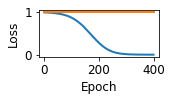

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5), tight_layout=True)
for losses in losses_all:
    ax.plot(np.arange(NEPOCH), losses, lw=2)
set_plot(ax, x_label='Epoch', y_label='Loss')

fig.savefig('ms/5_eprop_hold_loss.svg')